# Analisi Qualita' Dati RTP (PII, etc)

Questo notebook esegue una serie di passaggi per identificare la qualità di alcuni campi delle posizioni debitorie GPD.

## Caricamento librerie ed import recognizers

In [10]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider
from presidio_analyzer import PatternRecognizer, Pattern

In [11]:
import cml.data_v1 as cmldata

## Connessione DataLake & recupero dati "Causali"

In [12]:
CONNECTION_NAME = "dl-analysis-impala-vw"
conn = cmldata.get_connection(CONNECTION_NAME)

## Sample Usage to get pandas data frame
QUERY = """
select po.after.description
from pagopa.silver_gpd_payment_position pp
INNER JOIN pagopa.silver_gpd_payment_option po ON pp.after.id = po.after.payment_position_id
INNER JOIN pagopa.silver_gpd_transfer t ON t.after.payment_option_id = po.after.id
WHERE 
-- Regione Veneto Bollo Auto
-- pp.after.status IN ('PAID','REPORTED')
-- AND t.after.category IN ('0301105TS')
-- AND pp.after.organization_fiscal_code = '80007580279'

-- Regione Veneto TARI
-- pp.after.status in ('PAID','REPORTED')
-- and t.after.category in ('0201102IM', '0201133IM', '0101109IM','0101101IM')
-- and pp.after.organization_fiscal_code not in ('00145130597','00327470795','80002670604','81003590593')
-- LIMIT 5

-- All
pp.after.status IN ('PAID','REPORTED')
AND t.after.category IN ('0301105TS','0201102IM', '0201133IM', '0101109IM','0101101IM')
"""

dataframe = conn.get_pandas_dataframe(QUERY)
# print(dataframe)
# Closing the connection
conn.close()


## Analisi lunghezza causali

> 1 e <= 30 caratteri: 22046 record (1.62%)
> 30 e <= 50 caratteri: 251624 record (18.49%)
> 50 e <= 70 caratteri: 1793 record (0.13%)
> 70 e <= 100 caratteri: 623477 record (45.83%)
> 100 e <= 140 caratteri: 311991 record (22.93%)
> 140 caratteri: 0 record (0.00%)


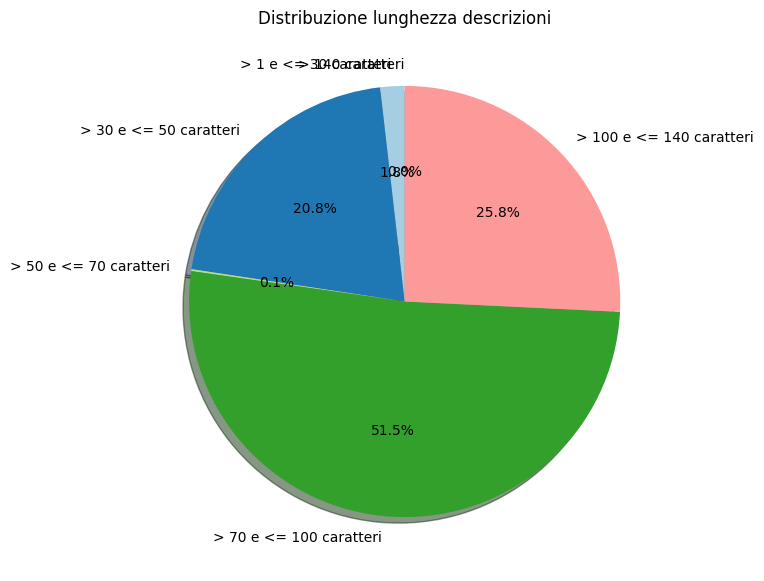

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_description_length(df):
    
    # Definizione delle categorie di lunghezza
    bins = [(1, 30), (31, 50), (51, 70), (71, 100), (101, 140), (141, float('inf'))]
    labels = ["> 1 e <= 30 caratteri", "> 30 e <= 50 caratteri", "> 50 e <= 70 caratteri", "> 70 e <= 100 caratteri", "> 100 e <= 140 caratteri", "> 140 caratteri"]
    
    total = len(df)
    counts = []
    percentages = []
    
    # Calcola il numero di record per ogni categoria
    for low, high in bins:
        count = len(df[(df['after.description'].str.len() > low) & (df['after.description'].str.len() <= high)])
        percentage = (count / total) * 100 if total > 0 else 0
        counts.append(count)
        percentages.append(percentage)
    
    # Stampa i risultati
    for label, count, percentage in zip(labels, counts, percentages):
        print(f"{label}: {count} record ({percentage:.2f}%)")
    
    if total == 0:
        print("Nessun record presente nel dataset. Diagramma a torta non generato.")
        return
    
    # Crea il diagramma a torta
    plt.figure(figsize=(7,7))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=plt.cm.Paired.colors, shadow=True, startangle=90)
    plt.title('Distribuzione lunghezza descrizioni')
    plt.show()

analyze_description_length(dataframe)

## Connessione DataLake & recupero dati "Debitore"

In [15]:
import cml.data_v1 as cmldata

CONNECTION_NAME = "dl-analysis-impala-vw"
conn = cmldata.get_connection(CONNECTION_NAME)

## Sample Usage to get pandas data frame
QUERY = """
select 
pp.after.fiscal_code,pp.after.organization_fiscal_code, pp.after.type
from pagopa.silver_gpd_payment_position pp
INNER JOIN pagopa.silver_gpd_payment_option po ON pp.after.id = po.after.payment_position_id
INNER JOIN pagopa.silver_gpd_transfer t ON t.after.payment_option_id = po.after.id
WHERE 
pp.after.status IN ('PAID','REPORTED')
AND t.after.category IN ('0301105TS','0201102IM', '0201133IM', '0101109IM','0101101IM')
"""

dataframe_debtor = conn.get_pandas_dataframe(QUERY)
# print(dataframe)
# Closing the connection
conn.close()

## Analisi Debtor

L'analisi di seguito non è fattibile su DL in quanto il CF del Debtor è tokenizzato con PDV

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider
import psycopg2
from tqdm import tqdm
import concurrent.futures

# NLP engine configuration (Spacy)
nlp_config = {
    "nlp_engine_name": "spacy",
    "models": [{"lang_code": "it", "model_name": "it_core_news_lg"}],
}
provider = NlpEngineProvider(nlp_configuration=nlp_config)
nlp_engine_with_italian = provider.create_engine()

# Initialize Presidio with the custom recognizer
analyzer = AnalyzerEngine(
    supported_languages=["en", "it"],
    nlp_engine=nlp_engine_with_italian,
)

#live
host = "pagopa-p-weu-gpd-pgflex.postgres.database.azure.com"
database = "apd"
user = "apduser"
password = "******"

DB_CONFIG = {
    "dbname": "nome_database",
    "user": "utente",
    "password": "password",
    "host": "hostname",
    "port": "5432"  # Cambia se necessario
}

# Query per estrarre i dati
QUERY = """
select 
pp.fiscal_code, pp.organization_fiscal_code, pp.type
from 
apd.apd.payment_position pp 
inner join apd.apd.payment_option po on pp.id  = po.payment_position_id 
inner join apd.apd.transfer t on t.payment_option_id  = po.id 
where 
pp.service_type = 'GPD' and pp.status in ('PAID','REPORTED')
AND t.category IN ('0301105TS','0201102IM', '0201133IM', '0101109IM','0101101IM')
"""

# Entities to detect (including IT_VEHICLE_PLATE)
entities = [
    "IT_VEHICLE_PLATE",  # Include Italian vehicle plates
    "IT_FISCAL_CODE",
    "IT_DRIVER_LICENSE", 
    "IT_VAT_CODE",       
    "IT_PASSPORT",       
    "IT_IDENTITY_CARD",  
    "CREDIT_CARD",       
    "DATE_TIME",         
    "EMAIL_ADDRESS",     
    "IBAN_CODE",         
    "PERSON",            
    "PHONE_NUMBER",      
]

# Connessione al database ed estrazione dati
try:
    # Connessione al database
    conn = psycopg2.connect(
            host=host,
            database=database,
            user=user,
            password=password
    )
    print("Connessione al database riuscita!")
    df = pd.read_sql_query(QUERY, conn)
    conn.close()
    
except Exception as e:
        print(f"Errore durante l'estrazione dei dati: {e}")
        exit()

def analyze_debtor(df):
    
    total = len(df)
    if total == 0:
        print("Nessun record presente nel dataset.")
        return
    
    # Funzione per validare il codice fiscale
    def is_valid_fiscal_code(text, entity):
        if pd.isna(text):
            return False
        results = analyzer.analyze(text=text, entities=[entity], language='it')
        return len(results) > 0

    # Progress bar per monitorare il calcolo
    df['valid_fiscal_code'] = None
    for i in tqdm(range(total), desc="Elaborazione codici fiscali", unit="record"):
        row = df.iloc[i]
        if row['type'] == 'F':
            df.at[i, 'valid_fiscal_code'] = is_valid_fiscal_code(row['fiscal_code'], 'IT_FISCAL_CODE')
        elif row['type'] == 'G':
            df.at[i, 'valid_fiscal_code'] = is_valid_fiscal_code(row['fiscal_code'], 'IT_VAT_CODE')
    
    # Conta le varie casistiche
    both_equal = (df['fiscal_code'] == df['organization_fiscal_code']).sum()
    both_different = (df['fiscal_code'] != df['organization_fiscal_code']).sum()
    fiscal_code_empty = df['fiscal_code'].isna().sum()
    org_fiscal_code_empty = df['organization_fiscal_code'].isna().sum()
    type_f = (df['type'] == 'F').sum()
    type_g = (df['type'] == 'G').sum()
    
    valid_fiscal_f = df[df['type'] == 'F']['valid_fiscal_code'].sum()
    valid_fiscal_g = df[df['type'] == 'G']['valid_fiscal_code'].sum()
    
    # Stampa i risultati
    print(f"Record con entrambi i campi uguali: {both_equal} ({both_equal / total * 100:.2f}%)")
    print(f"Record con entrambi i campi diversi: {both_different} ({both_different / total * 100:.2f}%)")
    print(f"Record con fiscal_code vuoto: {fiscal_code_empty} ({fiscal_code_empty / total * 100:.2f}%)")
    print(f"Record con organization_fiscal_code vuoto: {org_fiscal_code_empty} ({org_fiscal_code_empty / total * 100:.2f}%)")
    print(f"Record con type F: {type_f} ({type_f / total * 100:.2f}%)")
    print(f"Record con type G: {type_g} ({type_g / total * 100:.2f}%)")
    print(f"Record con fiscal_code valido per type F: {valid_fiscal_f} ({valid_fiscal_f / total * 100:.2f}%)")
    print(f"Record con fiscal_code valido per type G: {valid_fiscal_g} ({valid_fiscal_g / total * 100:.2f}%)")
    
    # Creazione grafici a torta
    def plot_pie_chart(labels, values, title):
        plt.figure(figsize=(6, 6))
        plt.pie(values, labels=labels, autopct='%1.1f%%', colors=plt.cm.Paired.colors, shadow=True, startangle=90)
        plt.title(title)
        plt.show()
    
    # Grafico Type F vs Type G
    plot_pie_chart(["Type F", "Type G"], [type_f, type_g], "Distribuzione Type F vs Type G")
    
    # Grafico campi uguali vs diversi
    plot_pie_chart(["Uguali", "Diversi"], [both_equal, both_different], "Distribuzione Campi Uguali vs Diversi")
    
    # Grafico codici fiscali validi per Type F
    plot_pie_chart(["Validi", "Non validi"], [valid_fiscal_f, type_f - valid_fiscal_f], "Validità Codici Fiscali per Type F")
    
    # Grafico Partite IVA valide per Type G
    plot_pie_chart(["Validi", "Non validi"], [valid_fiscal_g, type_g - valid_fiscal_g], "Validità Partite IVA per Type G")


    
analyze_debtor(df)


KeyboardInterrupt: 

## Connessione DataLake & recupero dati "Tassonomia"

In [2]:
import cml.data_v1 as cmldata

CONNECTION_NAME = "dl-analysis-impala-vw"
conn = cmldata.get_connection(CONNECTION_NAME)

## Sample Usage to get pandas data frame
QUERY = """
select 
t.after.category
from pagopa.silver_gpd_payment_position pp
INNER JOIN pagopa.silver_gpd_payment_option po ON pp.after.id = po.after.payment_position_id
INNER JOIN pagopa.silver_gpd_transfer t ON t.after.payment_option_id = po.after.id
WHERE 
pp.after.status IN ('PAID','REPORTED')
AND t.after.category IN ('0301105TS','0201102IM', '0201133IM', '0101109IM','0101101IM')
"""

dataframe_taxonomy = conn.get_pandas_dataframe(QUERY)
# print(dataframe)
# Closing the connection
conn.close()

## Analisi Tassonomia

Validazione tassonomia: 100%|██████████| 1360551/1360551 [00:02<00:00, 596943.26it/s]


Record con tassonomia valida: 0 (0.00%)
Record con tassonomia non valida: 1360551 (100.00%)


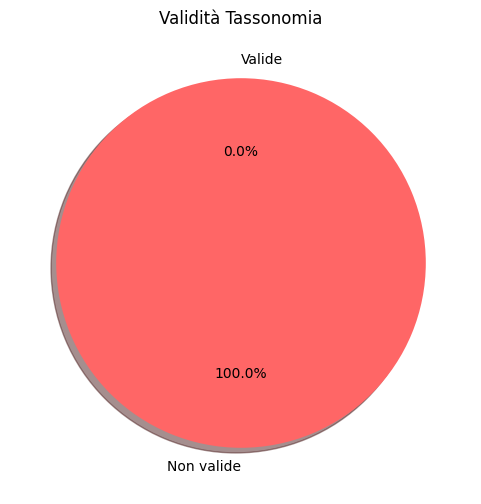

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

def validate_taxonomy_format(df):
    total = len(df)
    if total == 0:
        print("Nessun record presente nel dataset.")
        return
    
    # Regex per la validazione della tassonomia
    taxonomy_pattern = re.compile(r'\d{1,2}/?\d{2}\d{2}\d{3}(IM|TS|SP|SA|AP)/?')
    
    valid_count = 0
    invalid_count = 0
    
    tqdm.pandas(desc="Validazione tassonomia")
    df['valid_taxonomy'] = df['after.category'].progress_apply(lambda x: bool(taxonomy_pattern.fullmatch(str(x))) if pd.notna(x) else False)
    
    valid_count = df['valid_taxonomy'].sum()
    invalid_count = total - valid_count
    
    # Stampa i risultati
    print(f"Record con tassonomia valida: {valid_count} ({valid_count / total * 100:.2f}%)")
    print(f"Record con tassonomia non valida: {invalid_count} ({invalid_count / total * 100:.2f}%)")
    
    # Creazione grafico a torta
    plt.figure(figsize=(6, 6))
    plt.pie([valid_count, invalid_count], labels=["Valide", "Non valide"], autopct='%1.1f%%', colors=['#66b3ff', '#ff6666'], shadow=True, startangle=90)
    plt.title("Validità Tassonomia")
    plt.show()

validate_taxonomy_format(dataframe_taxonomy)

## Connessione DataLake & recupero dati "DueDate"

In [1]:
import cml.data_v1 as cmldata

CONNECTION_NAME = "dl-analysis-impala-vw"
conn = cmldata.get_connection(CONNECTION_NAME)

## Sample Usage to get pandas data frame
QUERY = """
select 
po.after.due_date
from pagopa.silver_gpd_payment_position pp
INNER JOIN pagopa.silver_gpd_payment_option po ON pp.after.id = po.after.payment_position_id
INNER JOIN pagopa.silver_gpd_transfer t ON t.after.payment_option_id = po.after.id
WHERE 
pp.after.status IN ('PAID','REPORTED')
AND t.after.category IN ('0301105TS','0201102IM', '0201133IM', '0101109IM','0101101IM')
"""

dataframe_duedate = conn.get_pandas_dataframe(QUERY)
# print(dataframe)
# Closing the connection
conn.close()

## Analisi Due date

Primo record: 1773615599999000


Elaborazione date: 100%|██████████| 1360551/1360551 [00:06<00:00, 213275.75 record/s]


Entro 10 anni: 1349135 record (99.16%)
Tra 10 e 20 anni: 0 record (0.00%)
Tra 20 e 30 anni: 0 record (0.00%)
Oltre 30 anni: 11416 record (0.84%)
  - 30/12/2099 11263
  - 31/12/2099 152
  - 31/12/9999 1


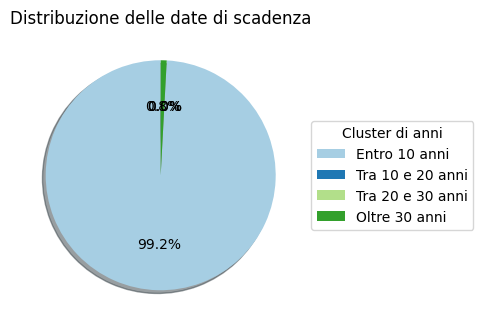

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from tqdm import tqdm
from collections import Counter

def analyze_due_dates(df):
    total = len(df)
    if total == 0:
        print("Nessun record presente nel dataset.")
        return
    
    # Debug: stampa il primo record
    print("Primo record:", df.iloc[0]['after.due_date'])
    
    # Definisci la data attuale
    today = datetime.now(timezone.utc)
    
    # Definisci i cluster di anni
    clusters = {
        "Entro 10 anni": 10,
        "Tra 10 e 20 anni": 20,
        "Tra 20 e 30 anni": 30,
        "Oltre 30 anni": float('inf')
    }
    
    # Conta i record per ciascun cluster
    cluster_counts = {key: [] for key in clusters.keys()}

    for date_val in tqdm(df['after.due_date'].dropna(), desc="Elaborazione date", unit=" record"):
        try: 
            # Converti da microsecondi a secondi
            timestamp_seconds = date_val / 1_000_000
            
            # Converte in datetime
            date_converted = datetime.fromtimestamp(timestamp_seconds,tz=timezone.utc)
            
            # Debug: stampa la data convertita
            #print(f"Valore originale: {date_val}, Data convertita: {date_converted}")
            
            delta_years = (date_converted - today).total_seconds() / (365 * 24 * 3600)  # Converti in anni
            
            for cluster, years in clusters.items():
                if delta_years <= years:
                    cluster_counts[cluster].append(date_converted.strftime("%d/%m/%Y"))
                    break
        except ValueError:
            continue
    
    # Stampa i risultati
    for cluster, dates in cluster_counts.items():
        count = len(dates)
        print(f"{cluster}: {count} record ({count / total * 100:.2f}%)")
        
        # Non stampare il dettaglio per "Entro 10 anni"
        if cluster != "Entro 10 anni":
            # Raggruppa le date identiche
            date_counts = Counter(dates)
        
            # Stampa ogni data con il suo totale
            for date, freq in date_counts.items():
                print(f"  - {date} {freq}")
    
    # Creazione grafico a torta
    #plt.figure(figsize=(6, 6))
    #plt.pie([len(dates) for dates in cluster_counts.values()], labels=cluster_counts.keys(), autopct='%1.1f%%', colors=plt.cm.Paired.colors, shadow=True, startangle=90)
    #plt.title("Distribuzione delle date di scadenza")
    #plt.show()

    # Creazione grafico a torta senza etichette sulla torta
    plt.figure(figsize=(5, 5))  # Aumenta la dimensione del grafico
    plt.pie([len(dates) for dates in cluster_counts.values()], autopct='%1.1f%%', colors=plt.cm.Paired.colors, shadow=True, startangle=90)

    # Sposta la legenda fuori dal grafico
    plt.legend(cluster_counts.keys(), title="Cluster di anni", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)
    plt.title("Distribuzione delle date di scadenza")
    
    # Aggiungi un po' di spazio per la legenda
    plt.subplots_adjust(right=0.7)
    plt.show()


analyze_due_dates(dataframe_duedate)


## Configurazione della lingua

In [4]:
# NLP engine configuration (Spacy)
nlp_config = {
    "nlp_engine_name": "spacy",
    "models": [{"lang_code": "it", "model_name": "it_core_news_lg"}],
}
provider = NlpEngineProvider(nlp_configuration=nlp_config)
nlp_engine_with_italian = provider.create_engine()


## Definizione del custom patter per le targhe

In [5]:
# Custom recognizer for Italian vehicle plates
#plate_pattern = Pattern(name="IT_VEHICLE_PLATE", regex=r"[A-Z]{2}\d{3}[A-Z]{2}|[A-Z]{2}\d{4}[A-Z]{2}|\d{2}[A-Z]{3}\d{2}", score=0.8)
plate_pattern = Pattern(name="IT_VEHICLE_PLATE", regex=r"\b([A-Z]{2}\d{3}[A-Z]{2}|\d{2}[A-Z]{2}\d{2}|[A-Z]{2}\d{5}|\d{2}[A-Z]{3}\d{2})\b", score=0.8)

plate_recognizer = PatternRecognizer(patterns=[plate_pattern], supported_entity="IT_VEHICLE_PLATE", name="IT_VEHICLE_PLATE", supported_language="it")


## Inizializzazione di Presidio 

In [6]:
# Initialize Presidio with the custom recognizer
analyzer = AnalyzerEngine(
    supported_languages=["en", "it"],
    nlp_engine=nlp_engine_with_italian,
)
analyzer.registry.add_recognizer(plate_recognizer)

anonymizer = AnonymizerEngine()

# Entities to detect (including IT_VEHICLE_PLATE)
entities = [
    "IT_VEHICLE_PLATE",  # Include Italian vehicle plates
    "IT_FISCAL_CODE",
    "IT_DRIVER_LICENSE", 
    "IT_VAT_CODE",       
    "IT_PASSPORT",       
    "IT_IDENTITY_CARD",  
    "CREDIT_CARD",       
    "DATE_TIME",         
    "EMAIL_ADDRESS",     
    "IBAN_CODE",         
    "PERSON",            
    "PHONE_NUMBER",      
]

## Analyzer & Anonymizer

In [7]:
# Funzione per anonimizzare il testo
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# Funzione per anonimizzare il testo
def anonymize_text(text):
    if not text:
        return text
    results = analyzer.analyze(text=text, entities=entities, language="it")
    return anonymizer.anonymize(text=text, analyzer_results=results).text

# Funzione wrapper per multiprocessing
def anonymize_wrapper(args):
    text, index, total = args
    if index % 50000 == 0 or index == total - 1:
        print(f"Elaborazione progresso: {index+1}/{total} righe completate.")
    return anonymize_text(text)

print("Inizio anonimizzazione con multiprocessing...")

# Configurazione tqdm
tqdm.pandas()

# Parallelizzazione con ProcessPoolExecutor
with ProcessPoolExecutor() as executor:
    dataframe["description_anon"] = list(
        tqdm(executor.map(anonymize_wrapper, zip(dataframe["after.description"], range(len(dataframe)), [len(dataframe)] * len(dataframe))), 
             total=len(dataframe))
    )

print("Anonimizzazione completata.")

# Salvataggio finale
dataframe.to_csv("anonimizzati.csv", index=False)
print("CSV generato con successo: anonimizzati.csv")


Inizio anonimizzazione con multiprocessing...
Elaborazione progresso: 1/1229953 righe completate.


  4%|▍         | 49959/1229953 [01:09<26:30, 741.72it/s]

Elaborazione progresso: 50001/1229953 righe completate.


  8%|▊         | 99988/1229953 [02:20<28:10, 668.39it/s]

Elaborazione progresso: 100001/1229953 righe completate.


 12%|█▏        | 149941/1229953 [03:30<26:36, 676.37it/s]

Elaborazione progresso: 150001/1229953 righe completate.


 16%|█▋        | 199971/1229953 [04:41<23:41, 724.61it/s]

Elaborazione progresso: 200001/1229953 righe completate.


 20%|██        | 249976/1229953 [05:53<22:00, 742.22it/s]

Elaborazione progresso: 250001/1229953 righe completate.


 24%|██▍       | 299945/1229953 [07:03<21:12, 730.59it/s]

Elaborazione progresso: 300001/1229953 righe completate.


 28%|██▊       | 349951/1229953 [08:13<22:34, 649.62it/s]

Elaborazione progresso: 350001/1229953 righe completate.


 33%|███▎      | 399938/1229953 [09:24<19:59, 692.16it/s]

Elaborazione progresso: 400001/1229953 righe completate.


 37%|███▋      | 449920/1229953 [10:34<17:40, 735.21it/s]

Elaborazione progresso: 450001/1229953 righe completate.

 37%|███▋      | 449996/1229953 [10:35<17:31, 741.45it/s]

 41%|████      | 499972/1229953 [11:46<16:21, 743.50it/s]

Elaborazione progresso: 500001/1229953 righe completate.


 45%|████▍     | 549938/1229953 [12:57<15:55, 711.43it/s]

Elaborazione progresso: 550001/1229953 righe completate.


 53%|█████▎    | 649946/1229953 [15:17<13:22, 722.70it/s]

Elaborazione progresso: 650001/1229953 righe completate.


 57%|█████▋    | 699909/1229953 [16:27<10:50, 815.32it/s]

Elaborazione progresso: 700001/1229953 righe completate.


 61%|██████    | 749985/1229953 [17:38<11:38, 687.24it/s]

Elaborazione progresso: 750001/1229953 righe completate.


 65%|██████▌   | 799954/1229953 [18:48<09:21, 766.18it/s]

Elaborazione progresso: 800001/1229953 righe completate.


 69%|██████▉   | 849950/1229953 [19:59<09:03, 699.55it/s]

Elaborazione progresso: 850001/1229953 righe completate.


 73%|███████▎  | 899959/1229953 [21:08<07:35, 724.02it/s]

Elaborazione progresso: 900001/1229953 righe completate.


 77%|███████▋  | 949959/1229953 [22:17<06:16, 743.20it/s]

Elaborazione progresso: 950001/1229953 righe completate.


 81%|████████▏ | 999943/1229953 [23:27<05:25, 707.51it/s]

Elaborazione progresso: 1000001/1229953 righe completate.


 85%|████████▌ | 1049932/1229953 [24:37<04:01, 746.43it/s]

Elaborazione progresso: 1050001/1229953 righe completate.


 89%|████████▉ | 1099972/1229953 [25:47<03:12, 676.02it/s]

Elaborazione progresso: 1100001/1229953 righe completate.


 98%|█████████▊| 1199993/1229953 [28:09<00:39, 755.84it/s]

Elaborazione progresso: 1200001/1229953 righe completate.


100%|█████████▉| 1229911/1229953 [28:52<00:00, 682.92it/s]

Elaborazione progresso: 1229953/1229953 righe completate.


100%|██████████| 1229953/1229953 [28:52<00:00, 709.96it/s]


Anonimizzazione completata.
CSV generato con successo: anonimizzati.csv


## Elaboro file csv e calcolo risultati di analisi

Righe totali: 1229953
IT_VEHICLE_PLATE -> 1079196
IT_FISCAL_CODE -> 781119
DATE_TIME -> 559714
PERSON -> 280587
PHONE_NUMBER -> 959364
IT_VAT_CODE -> 145906
IT_IDENTITY_CARD -> 20
CREDIT_CARD -> 1

Combinazioni di entità trovate:
SOLO IT_VEHICLE_PLATE -> 235252
DATE_TIME-IT_FISCAL_CODE-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER -> 104331
IT_FISCAL_CODE-IT_VEHICLE_PLATE-PHONE_NUMBER -> 211020
DATE_TIME-IT_FISCAL_CODE-IT_VEHICLE_PLATE-PHONE_NUMBER -> 307236
DATE_TIME-IT_FISCAL_CODE-PERSON-PHONE_NUMBER -> 44431
DATE_TIME-IT_FISCAL_CODE-PHONE_NUMBER -> 46376
DATE_TIME-IT_VAT_CODE-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER -> 7408
DATE_TIME-IT_VAT_CODE-IT_VEHICLE_PLATE-PHONE_NUMBER -> 22152
DATE_TIME-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER -> 18951
IT_FISCAL_CODE-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER -> 54086
DATE_TIME-IT_VAT_CODE-PHONE_NUMBER -> 1545
SOLO PERSON -> 6761
IT_VAT_CODE-IT_VEHICLE_PLATE-PHONE_NUMBER -> 93943
DATE_TIME-PERSON-PHONE_NUMBER -> 3222
IT_VAT_CODE-IT_VEHICLE_PLATE-PERSON-PHONE_NUMBER

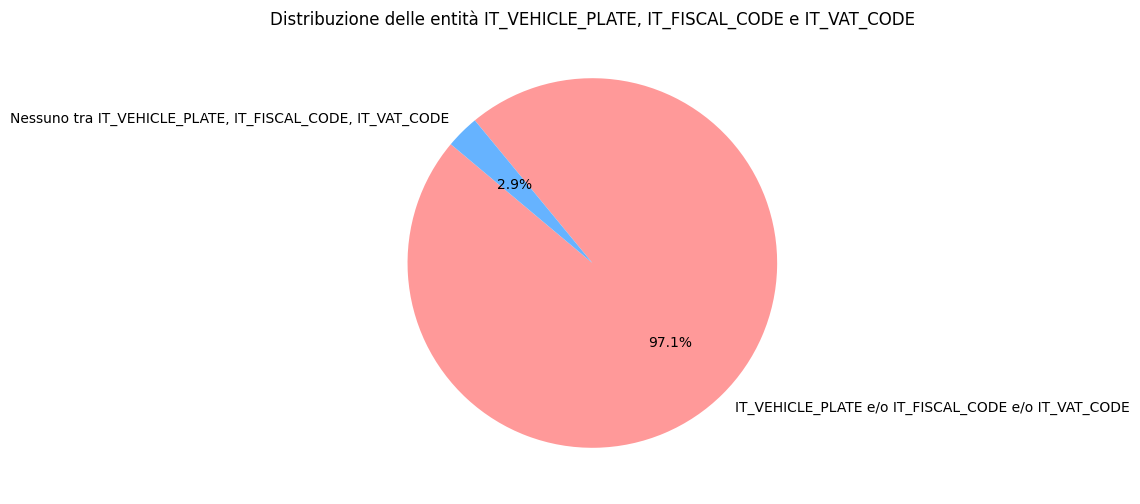

In [8]:
import csv
from collections import Counter
import matplotlib.pyplot as plt

# Definizione delle entità da cercare
ENTITIES = [
    "IT_FISCAL_CODE",
    "IT_DRIVER_LICENSE",
    "IT_VAT_CODE",
    "IT_PASSPORT",
    "IT_IDENTITY_CARD",
    "CREDIT_CARD",
    "DATE_TIME",
    "EMAIL_ADDRESS",
    "IBAN_CODE",
    "PERSON",
    "PHONE_NUMBER",
    "IT_VEHICLE_PLATE"
]

def analyze_csv(file_path):
    total_rows = 0
    entity_counts = Counter()
    combination_counts = Counter()
    
    targ_cf_vat_count = 0
    neither_targ_cf_vat_count = 0
    
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        
        for row in reader:
            total_rows += 1
            description_anon = row['description_anon']
            found_entities = [entity for entity in ENTITIES if f'<{entity}>' in description_anon]
            
            for entity in found_entities:
                entity_counts[entity] += 1
            
            if len(found_entities) == 1:
                combination_counts[f'SOLO {found_entities[0]}'] += 1
            elif found_entities:
                combination_counts['-'.join(sorted(found_entities))] += 1
            
            # Contatori specifici
            has_targa = "IT_VEHICLE_PLATE" in found_entities
            has_cf = "IT_FISCAL_CODE" in found_entities
            has_vat = "IT_VAT_CODE" in found_entities
            
            if has_targa or has_cf or has_vat:
                targ_cf_vat_count += 1
            else:
                neither_targ_cf_vat_count += 1
    
    # Output dei risultati
    print(f"Righe totali: {total_rows}")
    
    for entity, count in entity_counts.items():
        print(f"{entity} -> {count}")
    
    print("\nCombinazioni di entità trovate:")
    for combination, count in combination_counts.items():
        print(f"{combination} -> {count}")
    
    print("\nStatistiche specifiche:")
    print(f"IT_VEHICLE_PLATE e/o IT_FISCAL_CODE e/o IT_VAT_CODE -> {targ_cf_vat_count} ({(targ_cf_vat_count / total_rows) * 100:.2f}%)")
    print(f"Nessuno tra IT_VEHICLE_PLATE, IT_FISCAL_CODE, IT_VAT_CODE -> {neither_targ_cf_vat_count} ({(neither_targ_cf_vat_count / total_rows) * 100:.2f}%)")
    
    # Creazione grafico a torta
    labels = [
        "IT_VEHICLE_PLATE e/o IT_FISCAL_CODE e/o IT_VAT_CODE",
        "Nessuno tra IT_VEHICLE_PLATE, IT_FISCAL_CODE, IT_VAT_CODE"
    ]
    sizes = [targ_cf_vat_count, neither_targ_cf_vat_count]
    colors = ["#ff9999", "#66b3ff"]
    
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct="%.1f%%", colors=colors, startangle=140)
    plt.title("Distribuzione delle entità IT_VEHICLE_PLATE, IT_FISCAL_CODE e IT_VAT_CODE")
    plt.show()

# Esegui la funzione sul file CSV
analyze_csv("anonimizzati.csv")